In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utility

### Load dataset

In [2]:
tf_data, triple_data = Utility.load_dataset('dataset/','country_ind.csv')

### Split dataset in training and test set

In [3]:
training, testing = tf_data.split(random_state=1234)
print(training, testing)

### Build Knowledge Graph Embedding Model

In [6]:
model, results = Utility.create_model(training, testing, 'DistMult', 100, 'dataset/')

Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=512.


Evaluating on cuda:0:   0%|          | 0.00/466 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=222, num_relations=15, create_inverse_triples=False, num_triples=1863) to file:///C:/Users/rivasa/GitHub/Coypu/FederateQuery/dataset/DistMult/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/rivasa/GitHub/Coypu/FederateQuery/dataset/DistMult


In [7]:
results.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,inverse_harmonic_mean_rank,0.083651
1,tail,optimistic,inverse_harmonic_mean_rank,0.591144
2,both,optimistic,inverse_harmonic_mean_rank,0.337397
3,head,realistic,inverse_harmonic_mean_rank,0.083651
4,tail,realistic,inverse_harmonic_mean_rank,0.591144
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.991011
221,both,realistic,adjusted_hits_at_k,0.575575
222,head,pessimistic,adjusted_hits_at_k,0.156263
223,tail,pessimistic,adjusted_hits_at_k,0.991011


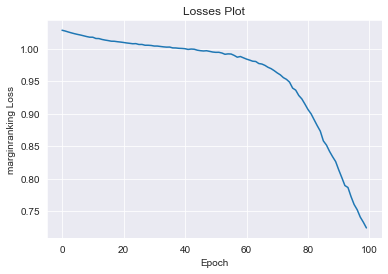

In [8]:
results.plot_losses()
plt.show()

### Obtain the embeddings of entities ans relations

In [9]:
entity_embedding_tensor, relation_embedding_tensor = Utility.get_learned_embeddings(model)
entity_embedding_tensor

tensor([[-0.1055, -0.0742,  0.0063,  ..., -0.0163,  0.1492,  0.0339],
        [ 0.0689,  0.0082, -0.0412,  ...,  0.0990,  0.1831, -0.0846],
        [-0.0137,  0.0029, -0.1765,  ...,  0.0779,  0.1704, -0.0086],
        ...,
        [-0.1663,  0.0119, -0.0178,  ...,  0.1032, -0.1895,  0.0165],
        [-0.2150,  0.0028,  0.0085,  ..., -0.1101,  0.1197, -0.0086],
        [ 0.2047,  0.0242, -0.0117,  ...,  0.0036,  0.1376, -0.0048]],
       device='cuda:0', grad_fn=<ViewBackward0>)

### Create pandas DataFrame with the embedding entity of type country

In [10]:
tf_dataset = pd.read_csv('dataset/country_ind.csv', delimiter=",")
entity = list(tf_dataset.country.unique())
df_predicted_entities, new_df, df_g1 = Utility.create_dataframe_predicted_entities(entity_embedding_tensor, entity, tf_data)
new_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
0,-0.105534,-0.074157,0.006339,0.076110,0.006087,-0.074803,0.198633,-0.011548,-0.003132,0.067153,...,0.164139,0.154071,0.085241,0.133105,-0.130889,0.178556,-0.016250,0.149195,0.033898,Afghanistan
1,0.068867,0.008214,-0.041243,-0.037212,-0.057823,-0.066201,0.039964,-0.026459,-0.037810,0.031009,...,-0.189760,-0.023203,0.098607,-0.032249,-0.040351,-0.132049,0.098956,0.183122,-0.084608,Albania
2,-0.013651,0.002930,-0.176489,-0.044155,0.059826,-0.182256,0.033724,0.142435,0.052668,0.140711,...,-0.000716,-0.106656,0.143042,-0.120867,-0.150899,-0.119656,0.077931,0.170383,-0.008567,Algeria
3,0.170137,-0.123867,0.033241,0.243743,0.042615,0.018117,-0.071695,0.090043,0.119365,-0.087743,...,-0.153930,0.140295,-0.040914,-0.120234,-0.094019,0.124279,0.225339,0.038410,0.074721,American Samoa
4,0.147709,0.035143,0.017849,0.140371,-0.035614,0.037412,-0.251118,-0.058422,0.000531,0.037438,...,-0.124620,0.008228,0.020862,0.066585,0.067600,-0.019352,0.119669,-0.083517,0.055262,Andorra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,0.218778,0.005398,0.002853,0.181122,0.065452,0.039933,-0.119052,-0.019546,-0.048719,0.072303,...,-0.083299,-0.051458,0.091878,0.037696,-0.019217,0.056721,-0.076180,0.252634,-0.100902,Virgin Islands (U.S.)
211,0.162375,0.056371,0.058063,0.217681,0.062405,-0.060259,0.086689,0.234017,0.093938,-0.006223,...,-0.007939,0.115437,0.018420,-0.008170,0.017745,-0.059043,-0.059325,-0.028717,-0.020289,West Bank and Gaza
212,-0.066841,-0.130743,-0.117175,0.097107,0.106452,-0.041256,0.180500,0.100599,0.006993,0.187221,...,0.064087,0.032761,0.039733,0.189717,0.124597,-0.041587,-0.075692,0.010204,0.059434,Yemen Rep.
213,-0.095949,-0.020436,-0.073569,0.020179,0.092178,0.071629,0.230894,-0.090778,0.052183,0.018621,...,0.303324,0.125601,0.039841,0.107263,-0.109264,0.113075,0.108324,0.179999,-0.062516,Zambia


## Create similarity matrix of country

In [11]:
sim_matrix, threshold = Utility.matrix_similarity(new_df, Utility.cosine_sim, 40)
Utility.SemEP_structure('semep-solver-master/datasets/country/matrix_country.tsv', sim_matrix, sep=' ')
sim_matrix

percentil 0.29715


,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Uruguay,Uzbekistan,Vanuatu,Venezuela RB,Vietnam,Virgin Islands (U.S.),West Bank and Gaza,Yemen Rep.,Zambia,Zimbabwe
Afghanistan,1.00000,0.38897,0.46090,0.12020,0.05381,0.75691,0.15148,0.26124,0.18075,0.34752,...,0.40905,0.70170,0.69258,0.33285,0.31529,0.26375,0.44729,0.74079,0.79768,0.75144
Albania,0.38897,1.00000,0.59935,0.49397,0.58645,0.18859,0.72336,0.47889,0.62812,0.43698,...,0.61612,0.57642,0.16752,0.35948,0.35221,0.63124,0.59082,0.34928,0.23672,0.20202
Algeria,0.46090,0.59935,1.00000,0.30123,0.24888,0.36395,0.39890,0.40247,0.50204,0.22236,...,0.42673,0.48252,0.35688,0.29239,0.28159,0.44163,0.49227,0.50319,0.39227,0.38689
American Samoa,0.12020,0.49397,0.30123,1.00000,0.72448,0.08795,0.64465,0.26735,0.46747,0.60322,...,0.23201,0.33837,0.05011,0.31717,0.26868,0.57936,0.58350,0.04628,0.07411,0.02452
Andorra,0.05381,0.58645,0.24888,0.72448,1.00000,0.09942,0.84241,0.16146,0.47367,0.58217,...,0.23702,0.21996,0.06184,0.16827,0.04295,0.56401,0.54327,0.00682,0.01664,0.07619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Virgin Islands (U.S.),0.26375,0.63124,0.44163,0.57936,0.56401,0.00235,0.70045,0.33814,0.35888,0.46070,...,0.48870,0.38476,0.11122,0.23848,0.14104,1.00000,0.58814,0.16534,0.16806,0.00144
West Bank and Gaza,0.44729,0.59082,0.49227,0.58350,0.54327,0.16027,0.66360,0.37138,0.37042,0.56849,...,0.49695,0.48136,0.22070,0.32344,0.26749,0.58814,1.00000,0.45152,0.23688,0.29932
Yemen Rep.,0.74079,0.34928,0.50319,0.04628,0.00682,0.65060,0.09157,0.26896,0.20934,0.24051,...,0.44665,0.53231,0.63776,0.44921,0.37872,0.16534,0.45152,1.00000,0.57920,0.64294
Zambia,0.79768,0.23672,0.39227,0.07411,0.01664,0.78475,0.05334,0.21885,0.12561,0.18796,...,0.18636,0.57900,0.68648,0.25666,0.23183,0.16806,0.23688,0.57920,1.00000,0.77899


## Create similarity matrix of categorical values of indicators

In [12]:
labels=['low', 'mediumLow', 'medium', 'mediumHigh', 'high']
val = [0,1,2,3,4]
sim_matrix_cat = pd.DataFrame(index=val, columns=val)
list_sim = []
gab = 0.25

for index in val:
    i = 1
    for indexC in range(index, len(val)):
        sim_matrix_cat.at[index, indexC] = i
        sim_matrix_cat.at[indexC, index] = i
        if index!=indexC:
            list_sim.append(i)
        i-=gab

threshold = np.percentile(list_sim, 30)
print("percentil", threshold)
sim_matrix_cat.index = labels
sim_matrix_cat.columns = labels
Utility.SemEP_structure('semep-solver-master/datasets/country/matrix_category.tsv', sim_matrix_cat, sep=' ')
sim_matrix_cat

percentil 0.42499999999999993


,low,mediumLow,medium,mediumHigh,high
low,1,0.75,0.5,0.25,0.0
mediumLow,0.75,1,0.75,0.5,0.25
medium,0.5,0.75,1,0.75,0.5
mediumHigh,0.25,0.5,0.75,1,0.75
high,0.0,0.25,0.5,0.75,1


## Save the files to execute SemEP

In [15]:
Utility.create_entitie(sim_matrix.columns.to_list(), 'semep-solver-master/datasets/country/country.txt')
Utility.create_entitie(sim_matrix_cat.columns.to_list(), 'semep-solver-master/datasets/country/category.txt')

In [16]:
tf_dataset['cost'] = 1.0
tf_dataset = tf_dataset[['country', 'category_indicator', 'indicator', 'cost']]
Utility.SemEP_structure('semep-solver-master/datasets/country/graph_country_category.tsv', tf_dataset, sep='\t')

In [83]:
./semEP -n 2 datasets/country/country.txt datasets/country/matrix_country.tsv 0.03 datasets/country/category.txt datasets/country/matrix_category.tsv 0.2 datasets/country/graph_country_category.tsv
